# Laboratorio 9 Detección de comunidades

En este laboratorio introduciremos los primeros conceptos para detectar comunidades bajo ciertas propiedades deseadas.


Contenidos:

1.   Particiones
2.   Cohesión y separación de una comunidad.
3.   Algoritmo de Girvan-Newman
3.   Algoritmo de Louvain


In [1]:
import itertools
import random
import networkx as nx
%matplotlib inline

# Particiones

Una **partición** de un gráfico es una separación de sus nodos en grupos disjuntos. Considere el siguiente gráfico:

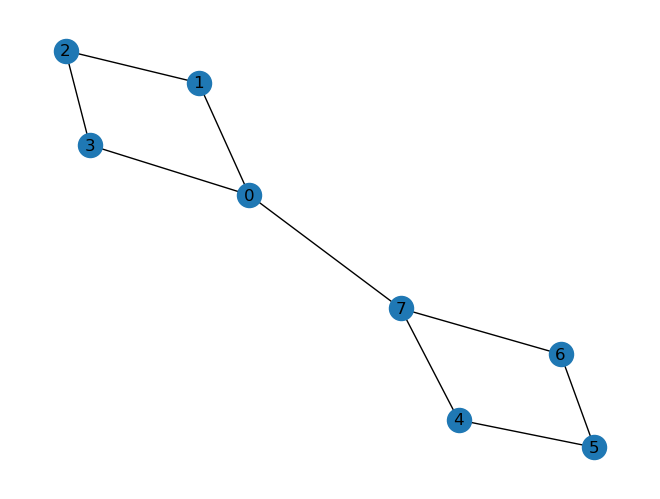

In [2]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)

El siguiente es un ejemplo de una partición de estos nodos:

In [3]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

Observe que cada nodo del gráfico está exactamente en uno de los conjuntos de la partición. Formalmente, una partición es una lista de conjuntos tal que cada nodo está exactamente en un conjunto. NetworkX puede verificar que nuestra partición es válida:

In [4]:
nx.community.is_partition(G, partition)

True

Al desarrollar algoritmos de detección de comunidades, a menudo utilizamos un mapa de partición, que es un diccionario que asigna nombres de nodos a un índice de partición. Esto es útil para comparar rápidamente si dos nodos están en el mismo clúster en la partición:

In [5]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

En este diccionario, las claves son los nombres de los nodos y dos nodos tendrán el mismo valor si están en la misma partición:

In [6]:
partition_map[0] == partition_map[7]

True

Podemos visualizar nuestra partición dibujando el gráfico con nodos coloreados según su pertenencia a la partición:

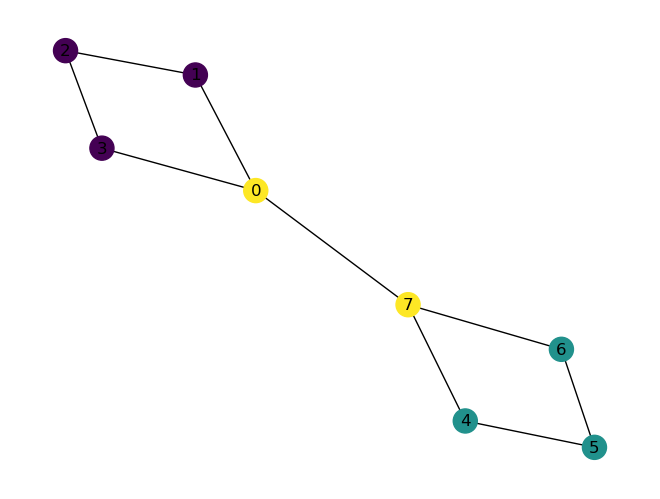

In [7]:
node_colors = [partition_map[n] for n in G.nodes]

nx.draw(G, node_color=node_colors, with_labels=True)

Hay dos particiones triviales:

1. La partición con un conjunto que contiene todos los nodos;
2. La partición con N conjuntos, cada uno de los cuales contiene un solo nodo.

Por tanto, una partición válida contiene entre 1 y N conjuntos.

Se aconseja experimentar cambiando la partición anterior y ejecutando la secuenciea celdas previas.

# Cohesión y separación de una comunidad.



Para efectos de esta clase, dado un grafo G, un subgrafo C de G se dice una comunidad de G si se cumple que:
1. C tiene una alta cohesión o densidad.
2. C tiene un nivel de separación del resto del gráfico.

Definitivamente, las definiciones de cohesión y separación no son únicas. Sin embargo, dependiendo del método utilizado siempre existirá una noción de ambas al momento de buscar comunidades.

A continuación veremos algunas definiciones y sus respectivo algoritmo para calcular variables de interés en la potencial busqueda de comunidades.




## a) Grado interno
El grado de v al contar sólo conexiones con nodos dentro de C.


In [8]:
def internal_degree(v, G, C):
  C_graph = G.subgraph(C)
  return C_graph.degree[v]

# Utilicemos el grafo anterior en el ejemplo:
C =  {1, 2, 3}
v = 3
internal_degree(v, G, C)

1

## b) Grado externo
El grado de v con respecto a nodos externos a C.

In [9]:
def external_degree(v, G, C):
  # Filtrar elementos de G.nodes que no están en C usando el conjunto
  G_C = [elemento for elemento in G.nodes if elemento not in C]

  G_C_graph = G.subgraph(G_C + [v])
  return G_C_graph.degree[v]

# Utilicemos el grafo anterior en el ejemplo:
C =  {0, 7}
v = 7
external_degree(v, G, C)

2

## c) Densidad interna
La densidad de C sin considerar aristas externas.

In [10]:
def internal_density(C ,G):
  C_graph = G.subgraph(C)
  return nx.density(C_graph)

C =  {4, 5, 6}
internal_density(C, G)

0.6666666666666666

## d) Volumen
La suma de todos los grados de los nodos que pertenecen a C.

In [11]:
def Volumen(C, G):
  return sum([d[1] for d in G.degree(C)])

C =  {4, 5, 6}
Volumen(C, G)

6

En general, cuando hablamos de cohesión nos referimos a una comunidad con alta densidad interna. Mientras que separación se refiere a una comunidad donde el grado externo es relativamente bajo con respecto a su volumen

# Métodos de Detección



## Modularidad

En un nivel alto, la detección de comunidades en redes consiste en encontrar una partición que logre una buena separación entre los grupos de nodos. Antes de entrar en cómo encontrar buenas particiones de un grafo, necesitamos un objetivo, una forma de medir qué tan buena es la partición. La modularidad es una de esas funciones objetivo.

La modularidad de una partición de un grafo compara el número de aristas intra-grupo con un valor base aleatorio. Puntuaciones de modularidad más altas corresponden a una mayor proporción de aristas intra-grupo, por lo tanto, menos aristas inter-grupo y una mejor separación de los grupos.

Para redes ponderadas no dirigidas, como describimos en clases, tenemos
$$
Q_w = \frac{1}{W}\sum_C \left(W_C - \frac{s_C^2}{4W}\right),
$$
donde
- $W$ es el peso total de los enlaces de la red,
- $W_C$ es el peso total de los enlaces internos del clúster $C$, y
- $s_C$ es la fuerza total de los nodos de $C$.

El peso total $W$ es la mitad de la fuerza total, por la misma razón por la cual el número de aristas $L$ es la mitad del grado total. Aunque esta fórmula puede verse un poco complicada, es directa escribir código para calcular la suma:

0.2222222222222222

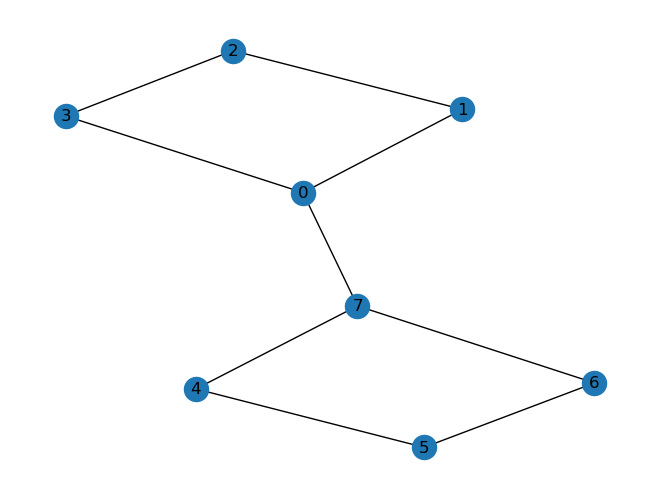

In [12]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)

    return summation / W

G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)
nx.draw(G, with_labels=True)

partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

modularity(G, partition)

Comparemos esto con una partición que sospecharíamos que tiene mayor modularidad:

In [13]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
modularity(G, partition_2)

0.3888888888888889

### Función NetworkX

NetworkX proporciona una función de modularidad que es más eficiente que la nuestra:

In [14]:
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

### Volvemos al Ejemplo: Zachary's Karate Club

Cada nodo en un gráfico NetworkX tiene un diccionario de *atributos* asociado a él. Este diccionario puede contener datos arbitrarios sobre un nodo. Podemos obtener los atributos de un solo nodo dándole el nombre del nodo al objeto "nodos".

Cada nodo en este gráfico tiene un atributo ``club'', que indica si el miembro siguió al instructor o al presidente después de la división:

{'club': 'Mr. Hi'}

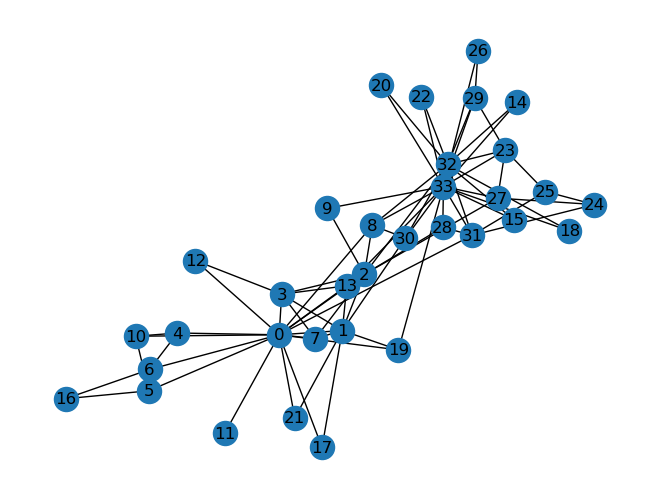

In [15]:
K = nx.karate_club_graph()
nx.draw(K, with_labels=True)
K.nodes[0]

Podemos visualizar estas etiquetas coloreando cada nodo según su atributo ``club'':

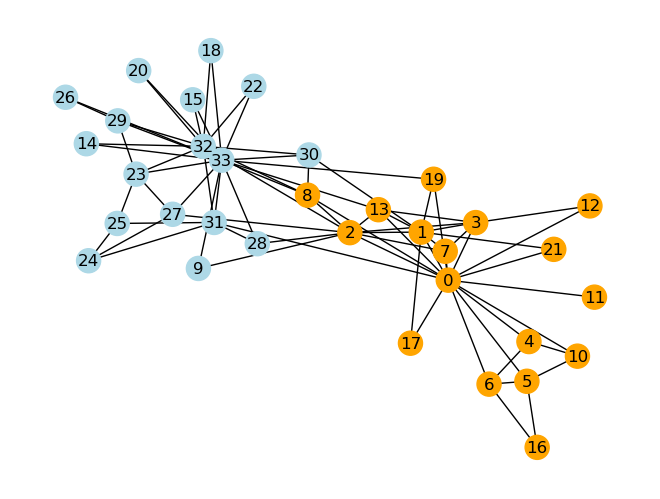

In [16]:
K = nx.karate_club_graph()
club_color = {
    'Mr. Hi': 'orange',
    'Officer': 'lightblue',
}
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]
nx.draw(K, node_color=node_colors, with_labels=True)

Esta separación parece buena, en el sentido de que hay relativamente pocos vínculos intercomunitarios en comparación con los vínculos intracomunitarios. Creemos una partición de gráfico basada en estas etiquetas y midamos su modularidad.

Podemos hacer esto creando un diccionario de dos conjuntos, uno para cada valor del atributo "club" de los nodos, y luego asignando los nodos al conjunto correspondiente.

In [17]:
groups = {
    'Mr. Hi': set(),
    'Officer': set(),
}

for n in K.nodes:
    club = K.nodes[n]['club']
    groups[club].add(n)

empirical_partition = list(groups.values())
empirical_partition

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

Verificamos que es una partición:

In [18]:
nx.community.is_partition(K, empirical_partition)

True

Dado que nuestra partición es de hecho una partición válida, podemos obtener la modularidad de esta partición:

In [19]:
nx.community.quality.modularity(K, empirical_partition)

0.39143756676224206

### Comparación con partición aleatoria

Para comparar, generemos una partición aleatoria de esta red y verifiquemos su modularidad. En este caso esperaríamos una modularidad cercana a cero.

Primero generamos una muestra de 17 nodos, la mitad del número total de nodos, y los asignamos a una comunidad. Nuestra segunda comunidad luego incluye los nodos en el gráfico que no están en la primera comunidad. Podemos usar algo de aritmética de conjuntos para hacer esto de manera concisa:

[{32, 33, 3, 4, 5, 9, 11, 12, 14, 15, 16, 17, 24, 25, 27, 30, 31}, {0, 1, 2, 6, 7, 8, 10, 13, 18, 19, 20, 21, 22, 23, 26, 28, 29}]
Modularidad partición aleatoria: 0.02753883922715092


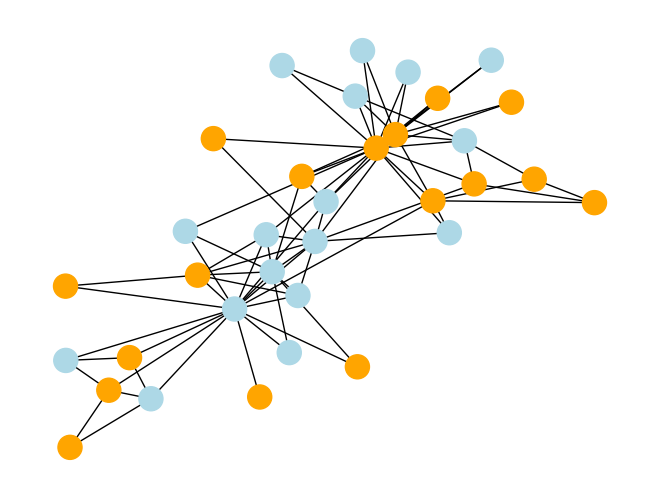

In [20]:
random_nodes = random.sample(list(K.nodes), 17)
random_partition = [set(random_nodes),
                    set(K.nodes) - set(random_nodes)]
print(random_partition)
random_node_colors = ['orange' if n in random_nodes else 'lightblue' for n in K.nodes]
nx.draw(K, node_color=random_node_colors)
print("Modularidad partición aleatoria:", nx.community.quality.modularity(K, random_partition))

Dado que se trata de un proceso aleatorio, la modularidad no será exactamente cero, pero debería ser bastante cercana. Continúe y repita el proceso de generar una partición aleatoria y probar su modularidad: fluctuará alrededor de su valor medio de cero.

## Algoritmo de Girvan-Newman

Nuestra tarea en esta parte será implementar el algoritmo de agrupamiento de Girvan-Newman. Dado que NetworkX puede hacer el trabajo pesado por nosotros (calcular betweenness centrality), la parte del código de la tarea es relativamente sencilla. La mayor parte de nuestro esfuerzo aquí se dedica a interpretar y explicar resultados intermedios.

Recuerde del texto el algoritmo de agrupamiento de Girvan-Newman:

1. Crea una secuencia de partición
   1. Calcule la betweenness centrality para todos los enlaces.
   2. Elimine el enlace con mayor betweenness y cree una partición utilizando componentes conexas.
   3. Vuelva a calcular la betweenness centrality de los enlaces del gráfico resultante.
   4. Repita desde el paso B hasta que no queden enlaces.
2. Evalúe cada partición de la secuencia y elija la que tenga mayor modularidad.

Durante este proceso, la cantidad de componentes conectados en el gráfico aumentará de manera monótona a medida que los grupos se divida. Dado que estamos eliminando un enlace a la vez, la cantidad de componentes conectados puede aumentar como máximo en uno entre los pasos de la secuencia; no es posible que un solo borde conecte más de dos nodos y, por lo tanto, componentes.

Esperamos que la partición resultante del gráfico se aproxime a su estructura comunitaria subyacente. Usaremos el gráfico de Karate Club aquí porque conocemos las etiquetas de la comunidad de verdad fundamental y podemos comparar el resultado obtenido del algoritmo.

### Crear una secuencia de partición


### A. Calcular la betweenness centrality para todos los enlaces.

NetworkX hace el trabajo pesado aquí. Todo lo que tenemos que hacer es comprender el resultado.

{(0, 1): 0.025252525252525245,
 (0, 2): 0.0777876807288572,
 (0, 3): 0.02049910873440285,
 (0, 4): 0.0522875816993464,
 (0, 5): 0.07813428401663694,
 (0, 6): 0.07813428401663695,
 (0, 7): 0.0228206434088787,
 (0, 8): 0.07423959482783014,
 (0, 10): 0.0522875816993464,
 (0, 11): 0.058823529411764705,
 (0, 12): 0.04652406417112298,
 (0, 13): 0.04237189825425121,
 (0, 17): 0.04012392835922248,
 (0, 19): 0.045936960642843,
 (0, 21): 0.040123928359222474,
 (0, 31): 0.1272599949070537,
 (1, 2): 0.023232323232323233,
 (1, 3): 0.0077243018419489,
 (1, 7): 0.007422969187675069,
 (1, 13): 0.01240556828792123,
 (1, 17): 0.01869960105254222,
 (1, 19): 0.014633732280791102,
 (1, 21): 0.01869960105254222,
 (1, 30): 0.032280791104320514,
 (2, 3): 0.022430184194890075,
 (2, 7): 0.025214328155504617,
 (2, 8): 0.009175791528732704,
 (2, 9): 0.030803836686189627,
 (2, 13): 0.007630931160342923,
 (2, 27): 0.04119203236850296,
 (2, 28): 0.02278244631185807,
 (2, 32): 0.06898678663384543,
 (3, 7): 0.00336558

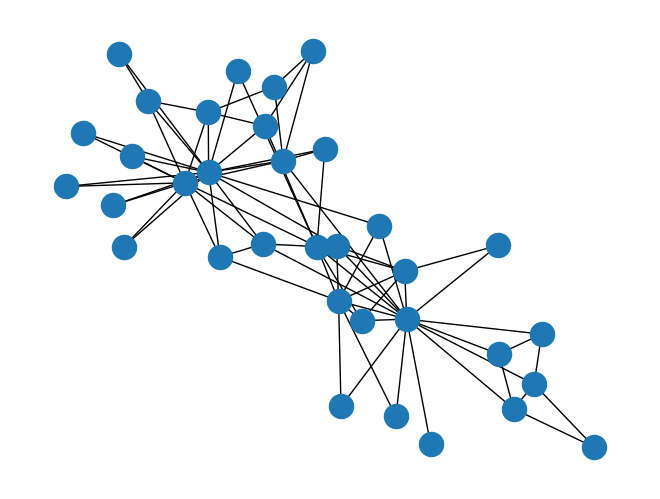

In [21]:
K = nx.karate_club_graph()
nx.draw(K)
nx.edge_betweenness_centrality(K)

El algoritmo para calcular la betweenness de todas las aristas en un gráfico cuesta aproximadamente lo mismo que calcularlo para una única arista, por lo que usaremos este diccionario con los valores calculados para cada arista.

Una vez calculado para todos las aristas, podemos obtener fácilmente la edge betweenness asociada para un sola arista. Por ejemplo, para obtener la edge betweenness de la arista entre los nodos 0 y 1:

In [22]:
# Forma 1
my_edge_betweenness = nx.edge_betweenness_centrality(K)
print(my_edge_betweenness[0, 1])

#Forma 2

print(my_edge_betweenness.get((0, 1)))

0.025252525252525245
0.025252525252525245


### B. Eliminar el enlace con mayor Betweenness...

Dado este diccionario de valores de betweenness para cada enlace, podemos hacer uso de la función incorporada `max` de Python para obtener la clave en este diccionario con el valor más grande. Dado que hay una clave en el diccionario para cada enlace en el grafo, las siguientes dos expresiones son equivalentes, pero la segunda probablemente sea más explícita sobre lo que estamos haciendo con esta declaración.

Estoy utilizando el nombre `my_edge_betweenness` para dejar claro que este es un diccionario que hemos nombrado y no una función de NetworkX.

In [23]:
# Forma 1
print(max(my_edge_betweenness, key=my_edge_betweenness.get))

#Forma 2
print(max(K.edges(), key=my_edge_betweenness.get))

(0, 31)
(0, 31)


Esta es la arista que deseamos eliminar en el siguiente paso:

In [24]:
my_edge_betweenness = nx.edge_betweenness_centrality(K)
most_valuable_edge = max(K.edges(), key=my_edge_betweenness.get)
K.remove_edge(*most_valuable_edge)

El "splat" en la última declaración anterior `G.remove_edge(*most_valuable_edge)` realiza la desempaquetación de tuplas en los argumentos de una función. Por ejemplo, si nuestro enlace más valioso es `(0, 31)`,

```python
G.remove_edge(*most_valuable_edge)
```

es lo mismo que

```python
G.remove_edge(most_valuable_edge[0], most_valuable_edge[1])
```

o

```python
G.remove_edge(0, 31)
```

### B.2 ...y crea una partición utilizando las componentes conexas.
Esta es casi una tarea sencilla porque la función `nx.connected_components()` nos da casi exactamente lo que queremos:

In [25]:
nx.connected_components(K)
list(nx.connected_components(K))

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}]

Recuerda: una partición es una lista de conjuntos donde cada nodo está exactamente en uno de estos conjuntos. Esto es justo lo que tenemos aquí, aunque es un poco aburrido porque solo hemos eliminado un enlace y aún hay un componente conectado. Si lo deseas, puedes intentar ejecutar las dos celdas anteriores varias veces hasta que tengas más de un componente conectado para que puedas ver cómo se ve.

Ten en cuenta que esta característica, en la que los componentes conectados corresponden exactamente a nuestras etiquetas de comunidad propuestas, es particular del algoritmo de Girvan-Newman. Otros algoritmos de agrupamiento pueden utilizar diferentes formas de generar sus particiones.

### C. Recalcular la betweenness centrality de las conexiones del grafo resultante



### D. Repetir desde el paso B hasta que no queden enlaces.

Esto implica que necesitamos un bucle para repetir este proceso $L$ veces, una vez por cada enlace, y que deberíamos llevar un registro de las particiones generadas. Cosas sencillas. Comenzaremos con un nuevo grafo del Club de Karate, ya que eliminamos algunos enlaces anteriormente:

In [26]:
K = nx.karate_club_graph()
partition_sequence = []
for _ in range(K.number_of_edges()):
    my_edge_betweenness = nx.edge_betweenness_centrality(K)
    most_valuable_edge = max(K.edges(), key=my_edge_betweenness.get)
    K.remove_edge(*most_valuable_edge)
    my_partition = list(nx.connected_components(K))
    partition_sequence.append(my_partition)

len(partition_sequence), nx.karate_club_graph().number_of_edges()

(78, 78)

Ten en cuenta la construcción idiomática de este bucle `for`. El uso de `_` como nombre de la variable del bucle le indica al lector que no esperamos hacer nada con la variable del bucle, simplemente queremos realizar una tarea un número específico de veces. Uno podría verse tentado a usar un bucle `while` aquí, pero eso puede llevar a errores y bucles infinitos, lo cual es un dolor de cabeza.

Si lo hemos hecho correctamente, deberíamos tener una partición para cada paso del proceso, es decir, una para cada enlace en el grafo.

La última partición también debería ser trivial, con cada nodo en su propia comunidad:

In [27]:
len(partition_sequence[-1]), nx.karate_club_graph().number_of_nodes()

(34, 34)

### E. Evaluar la modularidad de cada partición en la secuencia

Ahora tenemos una secuencia de particiones y una función para calcular la modularidad de una partición. ¡Este es un buen momento para usar una comprensión de lista!

In [28]:
G = nx.karate_club_graph()
modularity_sequence = [modularity(G, p) for p in partition_sequence]
modularity_sequence

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.34766027623170476,
 0.34766027623170476,
 0.34766027623170476,
 0.3423192968647515,
 0.3423192968647515,
 0.3423192968647515,
 0.3423192968647515,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.38497217068645645,
 0.37578006409175246,
 0.37578006409175246,
 0.3594760218136842,
 0.3594760218136842,
 0.3470699574595679,
 0.3470699574595679,
 0.333249002080171,
 0.333249002080171,
 0.3134405277262421,
 0.3134405277262421,
 0.3122598901819681,
 0.3122598901819681,
 0.3036862127771219,
 0.3036862127771219,
 0.2942973332583722,
 0.2942973332583722,
 0.2827158411573995,
 0.2827158411573995,
 0.27116245947414774,
 0.27116245947414774,
 0.2544648713479881,
 0.2544648713479881,
 0.2397537527407657,
 0.2397537527407657,
 0.22689792170311643,
 0.22299057363992422,
 0.22299057363992422,
 0.22299057363992422,
 0.20056783043796034,
 0.20056783043796034,
 0.1

Esta secuencia es entonces la modularidad de la partición en cada paso del algoritmo. Los primeros varios elementos de esta secuencia son efectivamente cero mientras hay solo una comunidad/componente, luego aumenta una vez que hay más de una comunidad. Podemos usar pyplot para visualizar esta relación:

Text(0.5, 0, 'Algorithm step')

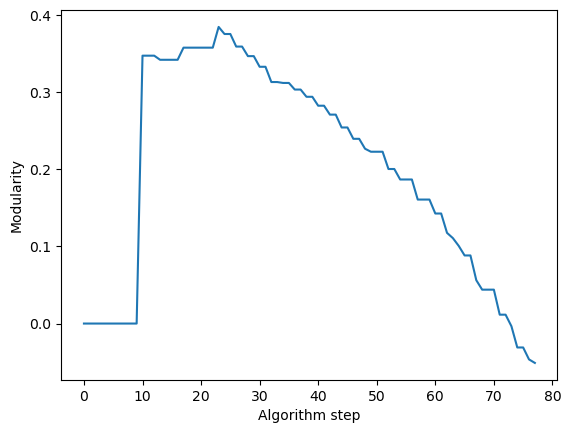

In [29]:
import matplotlib.pyplot as plt
plt.plot(modularity_sequence)
plt.ylabel('Modularity')
plt.xlabel('Algorithm step')

Ahora para encontrar ese punto máximo simplemente lo buscamos con la función `max()` y para encontrar el indice de dicho máximo (o etapa en que ocurrio) esta el método `list.index()`

In [30]:
## Encontramos el máximo elemento
modularidad_maxima = max(modularity_sequence)
# Encontrar el índice del elemento máximo
indice_maximo = modularity_sequence.index(modularidad_maxima)
best_partition = partition_sequence[indice_maximo]
print("Partición:", best_partition)
print("Modularidad Partición:",modularidad_maxima )

Partición: [{0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}]
Modularidad Partición: 0.38497217068645645


¡Interesante! ¡La partición del gráfico del club de karate con mayor modularidad en realidad tiene cinco componentes! Visualicémoslos, usando nuestro código para mapas de particiones que escribimos al comienzo de este tutorial:

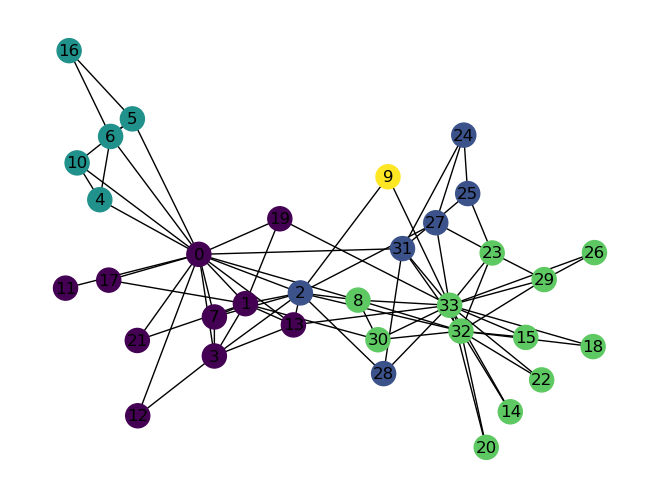

In [31]:
def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

best_partition_map = create_partition_map(best_partition)

node_colors = [best_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

Es más alto que las comunidades "ground truth" que evaluamos en la sección 3, lo cual es una buena señal, pero para el problema específico de tratar de predecir la membresía de la comunidad después de la división, una agrupación en cinco grupos no nos sirve.

### Obtener la mejor partición con un número dado de comunidades

Una de las partes más útiles del algoritmo de Girvan-Newman es que también es útil cuando tenemos un número específico de clústeres deseados. En este caso, sabemos que el club de karate se dividió en dos grupos, así que obtengamos la partición en la secuencia con dos componentes:

Partición 2 Cluster: [{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]
Modularidad Partición: 0.3476602762317048


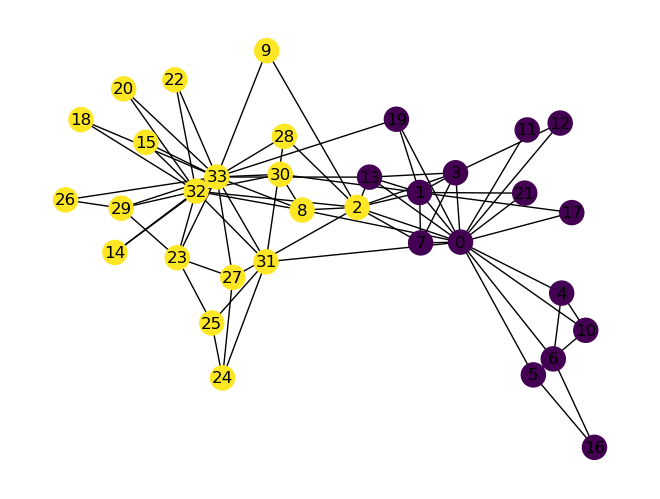

In [32]:
for partition in partition_sequence:
    if len(partition) == 2:
        two_cluster_partition = partition
        break

two_cluster_partition_map = create_partition_map(two_cluster_partition)

node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)


print("Partición 2 Cluster:",two_cluster_partition)
print("Modularidad Partición:", nx.community.quality.modularity(G, two_cluster_partition))

Bastante bueno, comparable a las etiquetas comunitarias que conocemos. Comparemos estos uno al lado del otro:

Text(0.5, 1.0, 'Actual communities')

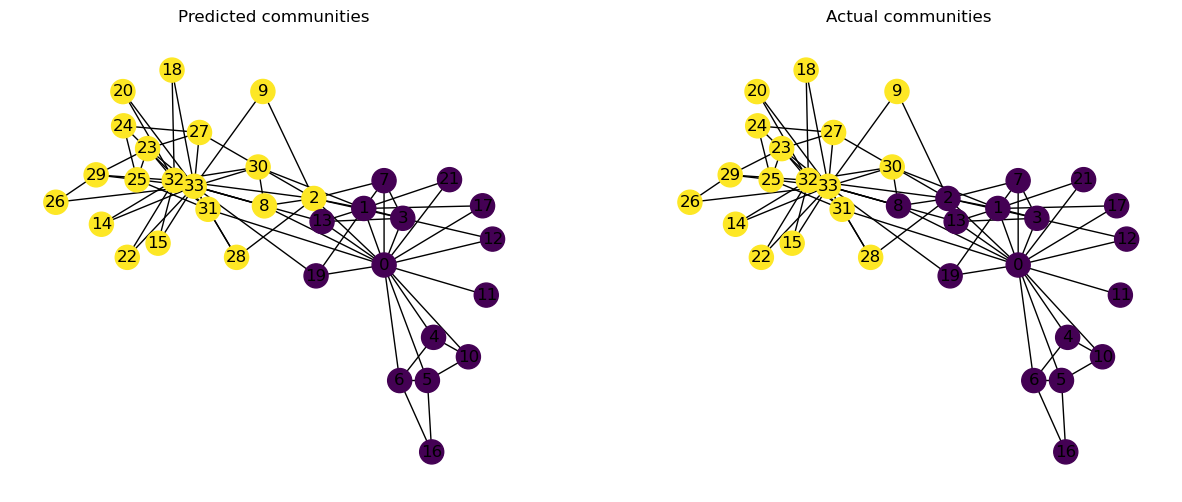

In [33]:
import matplotlib.pyplot as plt

pos = nx.layout.spring_layout(G)
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
two_cluster_partition_map = create_partition_map(two_cluster_partition)
node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Predicted communities')

plt.subplot(1, 2, 2)
node_colors = [G.nodes[n]['club'] == 'Officer' for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Actual communities')

Podemos ver que las etiquetas de comunidad predichas son bastante precisas y solo difieren en un par de nodos que, visualmente, parecen pertenecer a cualquiera de los grupos. El artículo original de Zachary incluso explica las consideraciones prácticas de uno de estos nodos mal predichos: el estudiante 8 estaba muy cerca de recibir su cinturón negro del Sr. Hi y por lo tanto no quería abandonar el grupo a pesar de que varios de sus amigos sí lo hicieron.

### Función NetworkX

`nx.community.girvan_newman(G)` generará una secuencia que contiene una partición de cada tamaño mayor que uno. Aquí podemos ver que los primeros son los mismos que los que generamos:

In [34]:
list(nx.community.girvan_newman(G))[:2]

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}),
 ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {9})]

## Algoritmo de Louvain

Nuestra tarea en esta parte será implementar el algoritmo de agrupamiento de Louvain. Intentamos encontrar la partición que maximiza la modularidad directamente. Esta es la idea principal detrás del algoritmo de Louvain, el cual busca maximizar la modularidad de manera “greedy” (o glotona).

Para un grafo G, comenzamos con una partición P donde cada nodo es un conjunto de la partición. Repetimos el siguiente procedimiento hasta que la modularidad de P no pueda incrementar más:

1. Por cada nodo v en G, agregamos v a la comunidad del vecino de v que maximiza el incremento en modularidad. Repetimos hasta que no haya incremento posible.
2. Dada la nueva partición P’, transformamos G en un grafo con pesos donde cada conjunto de P es un nuevo nodo y las aristas entre dos de estos nodos contienen la suma de los pesos entre nodos de las comunidades definidas en el paso 1.
3. Repetimos desde el comienzo con el nuevo grafo


### A. Partición Inicial

[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}]

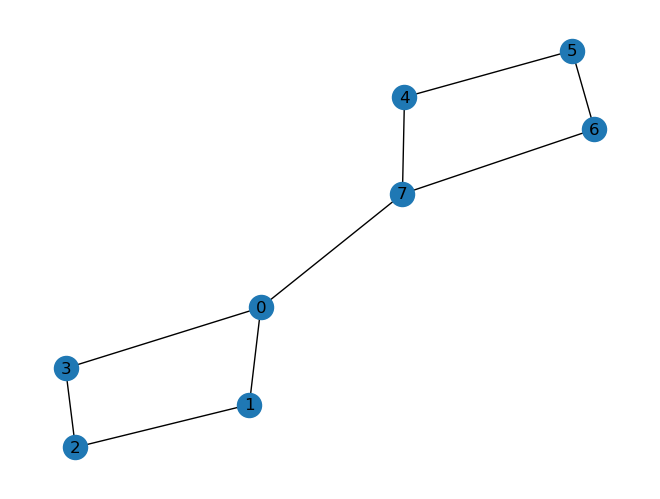

In [35]:
# Crear un grafo de ejemplo

G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)
# Inicializar cada nodo como su propia comunidad
def first_partition(G):
  return [{node} for node in G.nodes]

communities = first_partition(G)
communities


### B. Agregar nodo v al vecino que maximice la modularidad



Comenzamos realizando una función para cambiar un nodo v a la comunidad del nodo u.

In [36]:
# Cambiar partición el nodo v a la partición de u
def change_partition(v, u, P):

  P_aux = P.copy()
  community_of_v = [c.copy() for c in P if v in c][0]
  community_of_u = [c.copy() for c in P if u in c][0]
  # Cambio la comunidad del nodo v
  P_aux.remove(community_of_v)
  community_of_v.remove(v)
  P_aux.append(community_of_v)
  #Cambio la comunidad del nodo u
  P_aux.remove(community_of_u)
  community_of_u.add(v)
  P_aux.append(community_of_u)
  return P_aux


partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7}
]
change_partition(2, 5, partition)


[{0, 7}, {1, 3}, {2, 4, 5, 6}]

Ahora realizamos una función que dado un nodo v buscamos cual es el cambio (hacia las particiones de sus vecinos) que aumenta la modularidad.

In [37]:
def inc_mod(v, G, P):

  community_of_node = [c for c in P if v in c][0]
  modularity = nx.community.quality.modularity(G, P)
  prop_u = False
  for vecino in set(G.neighbors(v)) - community_of_node:
    # Nueva partición
    P_aux = change_partition(v, vecino, P)
    new_modularity = nx.community.quality.modularity(G, P_aux)

    if new_modularity > modularity:
      modularity = new_modularity
      prop_u = vecino

  if prop_u:
    return change_partition(v, prop_u, P)
  else:
    return P


inc_mod(7, G, partition)
#print(nx.community.quality.modularity(G, partition))
#print(nx.community.quality.modularity(G, inc_mod(1, G, partition) ))

[{1, 2, 3}, {0}, {4, 5, 6, 7}]

La siguiente función simplemente itera secuencialmente por los nodos, ejecutando la función anterior que maximiza la modularidad.

In [38]:
def for_inc_mod(G,P):

  nodes = list(G.nodes)
  random.shuffle(nodes)
  P_aux = P
  for nodes in nodes:
    P_aux = inc_mod(nodes, G, P_aux)

  if P_aux == P:
    return P_aux

  else:
    return for_inc_mod(G, P_aux)

partition_3 = [{1, 2}, {4, 5}, {6, 7}, {0, 3}]
random.seed(123)
Particiones_no_vacios = [conjunto for conjunto in for_inc_mod(G,partition_3) if conjunto]
Particiones_no_vacios

[{1, 2}, {4, 5}, {6, 7}, {0, 3}]

### C. Nuevo Grafo

Dada la nueva partición P’, transformamos G en un grafo con pesos donde cada conjunto de P es un nuevo nodo y las aristas entre dos de estos nodos contienen la suma de los pesos entre nodos de las comunidades definidas en el paso 1.



La función `Partition_Degree(G, P)` calcula los pesos de este nuevo grafo de supernodos.



In [39]:
def external_degree(v, G, C):
  # Filtrar elementos de G.nodes que no están en C usando el conjunto
  G_C = [elemento for elemento in G.nodes if elemento not in C]
  G_C_graph = G.subgraph(G_C + [v])
  return G_C_graph.degree[v]

def Partition_Degree(G, P):

  lista_edges = []
  dicts = {i: P[i] for i in range(len(P))}
  for  i,j in itertools.combinations(range(len(P)), 2):

    G_sub = G.subgraph(P[i].union(P[j]))
    degree = sum([external_degree(v, G_sub, P[i]) for v in P[i]])
    if degree > 0:
      lista_edges += [(i, j, degree)]

  K = nx.Graph()
  K.add_weighted_edges_from(lista_edges)
  return K,dicts




K,dicts = Partition_Degree(G, partition)
dicts

{0: {1, 2, 3}, 1: {4, 5, 6}, 2: {0, 7}}

Creamos una función para ir guardando las etiquetas reales de las particiones.

In [40]:
d_1 = {0: {5, 6}, 1: {1, 2}, 2: {0, 3}, 3: {4, 7}}
d_2 = {0: {0, 3}, 1: {1, 2}}
d_3 = {0: {0, 1}}
d_output = {0: {5, 6, 4, 7}, 1: {1, 2, 0, 3}}
def redef(d1, d2):

  d_aux = {}
  for k in d2.keys():
    d_aux[k] = []
    for l in d2[k]:
      d_aux[k]+=d1[l]

    d_aux[k] = set(d_aux[k])
  return d_aux


redef(d_2,d_3)
#d_2[1]

{0: {0, 1, 2, 3}}

Dadas las funciones que realizamos el codigo del algoritmo es mucho más fácil de comprender.

In [41]:
def partition_louvain_algorithm(G, n_iter = 100):

  G_or = G.copy()
  dicts_salida = {}
  dicts_interno = {}
  K=G
  for i in range(100):
    G = K
    # Partimos creando una partición donde cada conjunto tiene un solo nodo.
    communities = first_partition(G)
    ## Crea las nuevas particiones maximizando la modularidad
    Particiones_no_vacios = [conjunto for conjunto in for_inc_mod(G,communities) if conjunto]
    # Crea el nuevo grafo con supernodos
    K, dicts_aux = Partition_Degree(G, Particiones_no_vacios)
    dicts_interno[i] = dicts_aux.copy()
    # Realizamos el cambio de representación de los nodos
    for j in range(i):

      dicts_aux = redef(dicts_interno[i-j-1], dicts_aux)

    if dicts_aux == {}:
      break

    dicts_salida[i] = dicts_aux

  # Ahora buscamos que partición tiene mayor modularidad
  modularity_seq = [nx.community.quality.modularity(G_or, list(dicts_salida[i].values())) for i in dicts_salida]
  index = modularity_seq.index(max(modularity_seq))

  return [v for v in dicts_salida[index].values()]

partition_louvain_algorithm(G)





[{4, 5, 6, 7}, {0, 1, 2, 3}]

### Función NetworkX

`nx.community.louvain_communities(G)` generará la partición obtenida por el algoritmo Louvain.

In [42]:
nx.community.louvain_communities(G, seed = 123)

[{0, 1, 2, 3}, {4, 5, 6, 7}]

# Base de datos: World air traffic network

Para los ejercicios utilizaremos la base de datos [openflights World](https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience/raw/master/datasets/openflights/openflights_world.graphml.gz).
Para esto utilice el códifo siguiente o descargue manualmente y coloque el archivo en la carpeta `/content` (Si esta trabajando en Colab).

Los nodos en este grafo son aeropuertos, representados por sus códigos IATA; dos nodos están conectados por una arista si hay un vuelo programado que conecta directamente estos dos aeropuertos. Supondremos que este grafo es no dirigido, ya que un vuelo en una dirección generalmente implica que hay un vuelo de regreso.

In [43]:
import requests
import os

# URL del archivo comprimido en GitHub
url = "https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience/raw/master/datasets/openflights/openflights_world.graphml.gz"
response = requests.get(url)
# Carpeta de destino para la descarga
download_folder = os.getcwd()
filename = 'openflights_usa.graphml.gz'
# Guardar el archivo
with open(os.path.join(download_folder, filename), 'wb') as file:
    file.write(response.content)

G = nx.read_graphml(os.path.join(download_folder, filename))
print("Nodos:", list(G.nodes)[1:10])
print("Aristas:", list(G.edges)[1:5])
print("Número de Nodos: ", len(G.nodes))
print("Número de Aristas: ", len(G.edges))

Nodos: ['MAG', 'HGU', 'LAE', 'POM', 'WWK', 'NME', 'GOH', 'SFJ', 'THU']
Aristas: [('GKA', 'HGU'), ('GKA', 'LAE'), ('GKA', 'POM'), ('MAG', 'HGU')]
Número de Nodos:  3179
Número de Aristas:  18617
